In [1]:
import json as js


In [2]:
import os
import re

import pandas as pd

from process import *
from tokamak_helpers import *

In [3]:
iter_re = re.compile("converged after (\d+) iterations")

def get_iterations(files):
    iters = []
    for f in files:
        md = get_metadata(f.name)
        with open(f.path, "r") as file:
            for line in file:
                match = iter_re.search(line)
                if match:
                    iters.append(dict(**md, iter=int(match.group(1))))
    return iters


In [4]:
def ginkgo_non_solve_cost(db: Database):
    df_assembly = db.get_df("assembly")
    df_setup = db.get_df("set-up")
    df_cg_apply = db.get_df("cg solver apply")
    df_cgc = db.get_df("coarse grid solver")

    df_assembly.node = "assembly"
    df_setup.node = "setup"
    df_cg_apply.node = "cg_apply"
    df_cgc.node = "total"

    df = pd.concat([df_assembly, df_setup, df_cg_apply, df_cgc], sort=False)

    df = apply_filter(df)
    df = df[df.solver == "ginkgo"].drop(columns="solver")

    rt = df.groupby(["min_l", "node"]).sum()["max"].unstack("node")

    rt = rt.assign(rest=lambda df: df.total - (df.setup + df.assembly + df.cg_apply))

    return rt

In [5]:
before_json = [f.path for f in os.scandir("tokamak-mi100/") if "ginkgo" in f.name and ".json" in f.name]
before_db = Database(before_json)

In [6]:
costs_before = ginkgo_non_solve_cost(before_db)
costs_before


node,assembly,cg_apply,setup,total,rest
min_l,,,,,
0,0.000972,0.176719,0.105460,1.927634,1.644482
1,0.006511,0.269747,0.131947,2.376865,1.968660
2,0.049381,0.894550,0.247526,4.507428,3.315972
3,0.391872,2.376047,0.084128,5.023554,2.171507
4,3.338706,3.652877,0.078437,8.966324,1.896305
5,29.975894,14.941199,0.282375,49.723011,4.523543
6,259.202071,12.183814,1.050224,285.927049,13.490939


In [7]:
json_g = [f.path for f in os.scandir("tokamak-pa-mi100/") if ".json" in f.name]
json_p = [f.path for f in os.scandir("tokamak-mi100/") if "petsc" in f.name and ".json" in f.name]

In [8]:
db = Database(json_g + json_p)

In [9]:
df = db.get_df("coarse grid solver")

In [10]:
costs = ginkgo_non_solve_cost(db)
costs

node,assembly,cg_apply,setup,total,rest
min_l,,,,,
0.0,0.000511,0.645631,0.092669,0.776804,0.037993
1.0,0.001106,0.950366,0.094445,1.085458,0.039542
2.0,0.005027,1.251847,0.092006,1.394212,0.045331
3.0,0.033261,1.329838,0.130315,1.559492,0.066078
4.0,0.245907,3.287023,0.245811,4.073962,0.295221
5.0,2.343615,14.820400,0.460540,21.057529,3.432974
6.0,28.947610,11.686851,2.285037,46.655706,3.736207


In [11]:
apply_rt = pd.concat([costs_before.cg_apply.rename("seq"),
                      costs.cg_apply.rename("par")], axis=1)
apply_rt

,seq,par
min_l,,
0,0.176719,0.645631
1,0.269747,0.950366
2,0.894550,1.251847
3,2.376047,1.329838
4,3.652877,3.287023
5,14.941199,14.820400
6,12.183814,11.686851


In [16]:
asm_rt = pd.concat([costs_before.assembly.rename("seq"),
                    costs.assembly.rename("par")], axis=1)
asm_rt

,seq,par
min_l,,
0,0.000972,0.000511
1,0.006511,0.001106
2,0.049381,0.005027
3,0.391872,0.033261
4,3.338706,0.245907
5,29.975894,2.343615
6,259.202071,28.947610


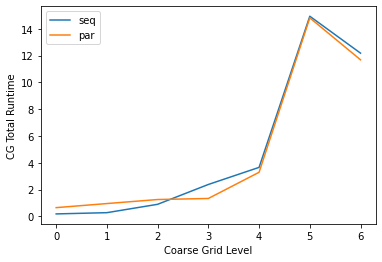

In [15]:
fig, ax = plt.subplots()
apply_rt.plot(ax=ax, legend=True)
ax.set_ylabel("CG Total Runtime")
ax.set_xlabel("Coarse Grid Level")
fig.savefig("cg_apply_runtime")


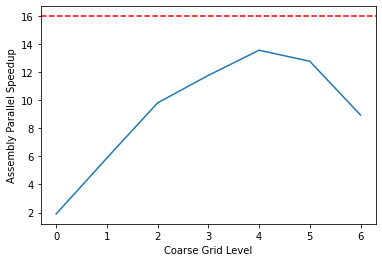

In [26]:
fig, ax = plt.subplots()
(asm_rt.seq / asm_rt.par).plot(ax=ax, legend=False)
ax.axhline(16, c="r", ls="--", label="Ideal")
ax.set_ylabel("Assembly Parallel Speedup")
ax.set_xlabel("Coarse Grid Level")
#ax.set_yscale("log")
fig.savefig("asm_speedup")
